## Imports

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

sns.set_style('whitegrid')

In [3]:
brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma' , 'bb_kt_hilim']

## Load Data

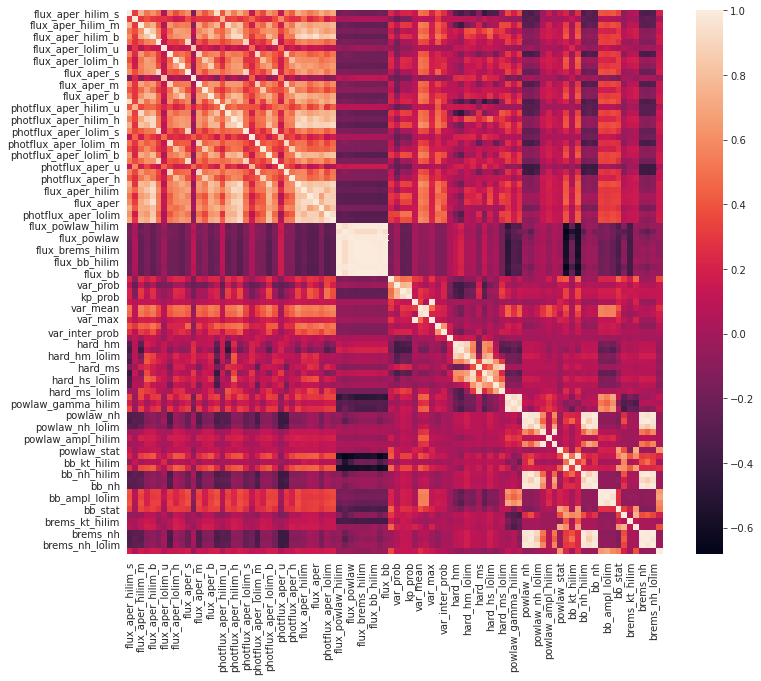

In [2]:
data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id').iloc[: , 1:]
feat_feat_corr = data_all.drop(columns=['class' , 'src_n' , 'src_id' , 'significance']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(feat_feat_corr)
plt.show()

### Fuctions

In [8]:
# Create res data
def create_res_data( clf , x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_bh = pred_prob[:,0]
    pred_prob_ns = pred_prob[:,1]
    pred_prob = [np.amax(pi) for pi in pred_prob]
    res =  x.copy()
    global feat_names_sorted 
    res = res[feat_names_sorted]
    #id_data = id_data.reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(1 , 'true_class' , y)
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'BH_prob' , pred_prob_bh)
    res.insert(5 , 'NS_prob' , pred_prob_ns)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    return res


In [9]:
# detect outliaers funcion
from sklearn.preprocessing import scale
import json
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        #print(c)
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return out


In [10]:
# Drop Params and check model performance
from sklearn.metrics import roc_curve , det_curve , roc_auc_score
def evaluate_clf(data_sent , remove_params = [] , drop_brems=True):
    data_all = data_sent.copy()
    np.random.seed(433)
    data = data_all.sample(frac=1)
    data_label = data['class']
    x = data.copy()
    brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
    inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma' , ]
    print('REMOVING features : ' , remove_params)
    if(drop_brems):
        x = x.drop(columns = brems_model+ inter_obs_param + remove_params)
    else : 
        x = x.drop(columns = inter_obs_param + remove_params)
    y = data_label.copy()
    # Find and fit besst model
    train_acc = []
    test_acc = []
    best_clf = ''
    score = 0 
    for i in tqdm(range(20)):
        rs = int(np.random.uniform(0,999999))
        np.random.seed(rs)
        df =  x.sample(frac=1 , random_state=rs)
        y = df['class']
        x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.2 , shuffle=True, random_state=10 , stratify=y)
        info_col = ['src_n' , 'src_id' , 'significance' , 'class']
        id_train = x_train[info_col]
        id_test = x_test[info_col]
        y_train = x_train['class']
        y_test = x_test['class']
        x_train = x_train.drop(info_col , axis=1)
        x_test = x_test.drop(info_col , axis = 1 )
        #np.random.seed(5926)
        clf = RandomForestClassifier(
            n_estimators= 222 , 
            criterion='entropy' ,
            random_state=12,
            max_depth=85 , 
            min_samples_leaf= 2 , 
            min_samples_split=2 , 
            bootstrap=False ,
            max_features='sqrt' ,
            class_weight='balanced'
            )
        clf.fit(x_train , y_train)
        tr = clf.score(x_train , y_train)
        next_score = clf.score(x_test , y_test)
        test_acc.append(next_score)
    print('Parmas Used : ' , x_train.shape[1])
    print('Mean accuracy : ' , np.mean(test_acc))
    print('Sigma accuracy : ' , np.std(test_acc))

    # Entropy wise feature importance

    feat_imp = clf.feature_importances_
    print('Features used:' , len(feat_imp))
    feat_names = x_train.columns.to_list()
    feat = pd.DataFrame()
    feat.insert( 0 , 'feat_name' , feat_names)
    feat.insert(1 , 'feat_imp' , feat_imp)
    feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
    global feat_names_sorted
    feat_names_sorted = feat['feat_name']
    #feat.to_csv('result/feat_imp.csv')

    train_res = create_res_data(clf , x_train , y_train ,id_train , cl_type='train')
    test_res = create_res_data(clf , x_test , y_test ,id_test , cl_type='test')
    res_data = pd.concat([train_res , test_res])
    #res_data.to_csv('result/res_rf_tuned_rf_impute.csv')
    res_data

    # Bake result

    train_res = create_res_data(clf , x_train , y_train ,id_train , cl_type='train')
    test_res = create_res_data(clf , x_test , y_test ,id_test , cl_type='test')
    res_data = pd.concat([train_res , test_res])

    res_data

    data =  res_data.copy()
    total = len(data)

    roc_auc = roc_auc_score(res_data['true_class'] , res_data['NS_prob'])
    print('ROC_AUC :' , roc_auc)
    # Find feature importance

    feat_imp = clf.feature_importances_ 
    result = class_feature_importance(x_train , y_train , feat_imp)


    feat_names = x_train.columns.to_list()
    values = list(result['NS'].values())
    df=  pd.DataFrame()
    df.insert(0 , 'feat_name' , feat_names)
    df.insert(1 , 'feat_imp' , values)
    df = df.sort_values(by='feat_imp' , ascending=False)
    df_feat_ns = df.copy()

    values = list(result['BH'].values())
    df=  pd.DataFrame()
    df.insert(0 , 'feat_name' , feat_names)
    df.insert(1 , 'feat_imp' , values)
    df = df.sort_values(by='feat_imp' , ascending=False)
    df_feat_bh = df.copy()

    sns.set_style('whitegrid')
    top_feat = 16
    fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(14 ,10))
    palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
    ax1 = sns.barplot(data = df_feat_ns.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[0] )

    palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
    ax2 = sns.barplot(data = df_feat_bh.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[1] )
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.invert_xaxis()
    ax1.set_title('NS Feature Importance')
    ax2.set_title('BH Feature Importance')
    ax1.text(0.01, 4  , 'avg acc: {:.4f} \n Std acc {:.4f}'.format(np.mean(test_acc) , np.std(test_acc)))
    #plt.show()
    return df_feat_bh , df_feat_ns , fig , np.mean(test_acc) , np.std(test_acc) , x_train.shape[1] , roc_auc

## Test on All features

### remove features in iteration

In [ ]:
#data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id').iloc[: , 1:]
#feat_feat_corr = data_all.drop(columns=['class' , 'src_n' , 'src_id' , 'significance']).corr().abs()
#feat_feat_corr
#display(data_all)
#display(feat_feat_corr)
feat_names_sorted = ''
to_rem_ns = []
to_rem_bh = []
mean_acc = []
std_acc = [] 
num_params = []
roc_auc = []
f_bh , f_ns , fig , _ , _ , _ , _ = evaluate_clf(data_all , to_rem_ns)
for i in tqdm(range(16)):
    curr_imp_ns = f_ns.iloc[i]['feat_name']
    curr_imp_bh = f_bh.iloc[i]['feat_name']
    for j in tqdm(range(1,6)):
        next_corr = feat_feat_corr[[curr_imp_ns]].sort_values(by = curr_imp_ns , ascending=False ).iloc[j].name
        to_rem_ns.append(next_corr)
        next_corr = feat_feat_corr[[curr_imp_bh]].sort_values(by = curr_imp_bh , ascending=False ).iloc[j].name
        to_rem_bh.append(next_corr)
    to_rem = list(np.union1d(to_rem_ns , to_rem_bh))
    #print('Removing Params' , to_rem)
    f_bh , f_ns ,  fig , mean , std , n_params , ra = evaluate_clf(data_all , to_rem)
    mean_acc.append(mean)
    std_acc.append(std)
    roc_auc.append(ra)
    num_params.append(n_params)
    plt.savefig('result/plots/removing_params/'+str(i)+'X'+str(j)+'.jpg')
    #plt.show()
    plt.close()

### Final feature correlation

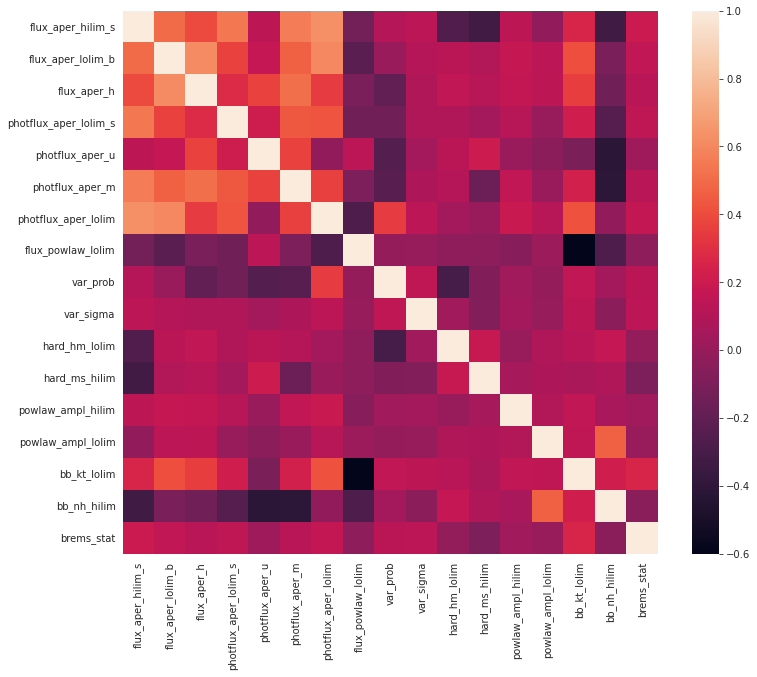

In [9]:
small_feat_feat_corr = data_all.drop(columns=['class' , 'src_n' , 'src_id' , 'significance']+to_rem+brems_model+inter_obs_param).corr()
plt.figure(figsize=(12,10))
sns.heatmap(small_feat_feat_corr)
plt.show()

/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


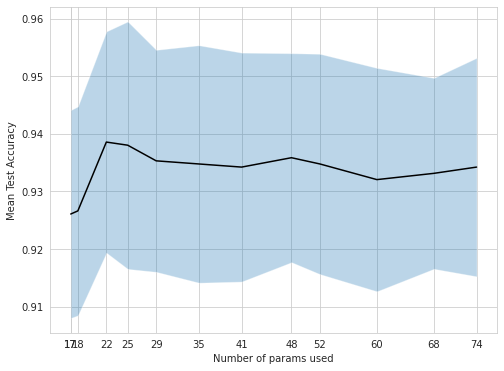

In [11]:
fig , ax = plt.subplots(figsize=(8,6))
st = len(num_params)-3
plt.plot(num_params[:st] , mean_acc[:st] , 'k')
u_lim = [m+s for m,s in zip(mean_acc , std_acc)]
l_lim = [m-s for m,s in zip(mean_acc , std_acc)]
plt.fill_between(num_params[:st] , u_lim[:st] , l_lim[:st] , alpha=0.3)
plt.ylabel('Mean Test Accuracy')
plt.xlabel('Number of params used')
ax.set_xticklabels(num_params[:st][::-1])
ax.set_xticks(num_params[:st][::-1])
plt.show()

## No model-fit params

### Remove model fit features

In [12]:
data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id').iloc[: , 1:]
model_fit_feat = ['powlaw_gamma','powlaw_gamma_hilim','powlaw_gamma_lolim','powlaw_nh','powlaw_nh_hilim','powlaw_nh_lolim','powlaw_ampl','powlaw_ampl_hilim','powlaw_ampl_lolim','powlaw_stat','bb_kt','bb_kt_hilim','bb_kt_lolim','bb_nh_hilim','bb_nh_lolim','bb_nh','bb_ampl','bb_ampl_lolim','bb_ampl_hilim','bb_stat','brems_kt','brems_kt_hilim','brems_kt_lolim','brems_nh','brems_nh_hilim','brems_nh_lolim','brems_stat' ,  'flux_powlaw_hilim','flux_powlaw_lolim','flux_powlaw','flux_brems_lolim','flux_brems_hilim','flux_brems','flux_bb_hilim','flux_bb_lolim','flux_bb',]
data_all = data_all.drop(columns=model_fit_feat)

### Check correlation

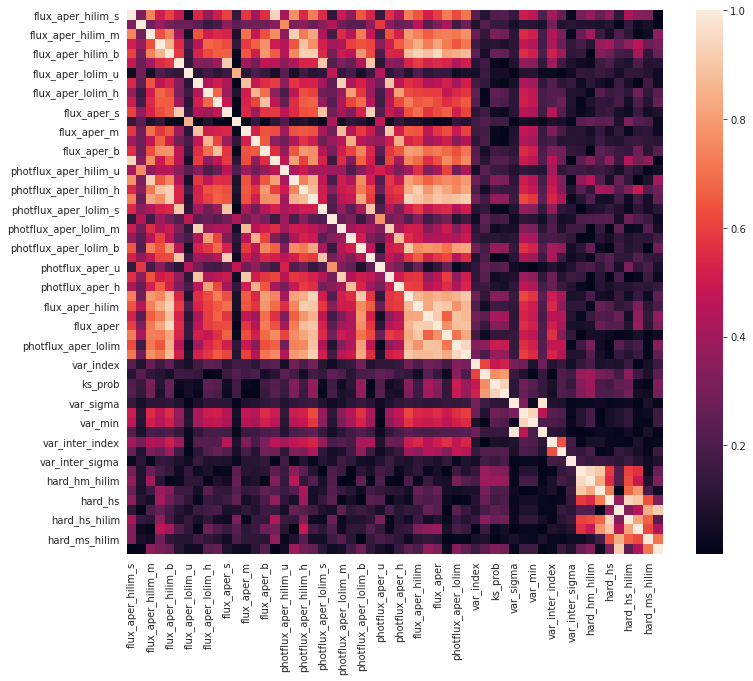

In [13]:
#data_all =  pd.read_csv('../processed_data/train_none_rf_impute' , index_col = 'obs_id').iloc[: , 1:]
feat_feat_corr = data_all.drop(columns=['class' , 'src_n' , 'src_id' , 'significance']).corr().abs()
feat_feat_corr
plt.figure(figsize=(12,10))
sns.heatmap(feat_feat_corr)
plt.show()

REMOVING features :  []


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Parmas Used :  53
Mean accuracy :  0.8983695652173914
Sigma accuracy :  0.01891273113185361
Features used: 53
ROC_AUC : 0.9990778774415291


100%|██████████| 3/3 [00:00<00:00, 270.66it/s]


REMOVING features :  ['flux_aper_hilim_u', 'kp_prob', 'ks_prob', 'photflux_aper_lolim_u', 'photflux_aper_u', 'var_prob']


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Parmas Used :  47
Mean accuracy :  0.8842391304347827
Sigma accuracy :  0.02461302581353097
Features used: 47
ROC_AUC : 0.9989102187945345


100%|██████████| 3/3 [00:00<00:00, 394.93it/s]


REMOVING features :  ['flux_aper_hilim_u', 'flux_aper_m', 'hard_hs', 'hard_hs_hilim', 'hard_hs_lolim', 'kp_prob', 'ks_prob', 'photflux_aper_lolim_m', 'photflux_aper_lolim_u', 'photflux_aper_m', 'photflux_aper_u', 'var_prob']


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Parmas Used :  41
Mean accuracy :  0.8820652173913043
Sigma accuracy :  0.026239364575159362
Features used: 41
ROC_AUC : 0.9986377734931678


100%|██████████| 3/3 [00:00<00:00, 256.09it/s]


REMOVING features :  ['flux_aper_hilim_u', 'flux_aper_lolim_m', 'flux_aper_m', 'hard_hs', 'hard_hs_hilim', 'hard_hs_lolim', 'kp_prob', 'ks_prob', 'photflux_aper_lolim_m', 'photflux_aper_lolim_u', 'photflux_aper_m', 'photflux_aper_u', 'var_max', 'var_mean', 'var_prob', 'var_sigma']


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Parmas Used :  37
Mean accuracy :  0.8793478260869565
Sigma accuracy :  0.02328726661481362
Features used: 37
ROC_AUC : 0.9985958588314192


100%|██████████| 3/3 [00:00<00:00, 368.17it/s]


REMOVING features :  ['flux_aper_hilim', 'flux_aper_hilim_u', 'flux_aper_lolim_m', 'flux_aper_lolim_u', 'flux_aper_m', 'flux_aper_u', 'hard_hs', 'hard_hs_hilim', 'hard_hs_lolim', 'kp_prob', 'ks_prob', 'photflux_aper_hilim', 'photflux_aper_hilim_b', 'photflux_aper_lolim_m', 'photflux_aper_lolim_u', 'photflux_aper_m', 'photflux_aper_u', 'var_max', 'var_mean', 'var_prob', 'var_sigma']


100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Parmas Used :  32
Mean accuracy :  0.8809782608695652
Sigma accuracy :  0.02605863498855837
Features used: 32
ROC_AUC : 0.9985958588314192


100%|██████████| 4/4 [01:03<00:00, 15.88s/it]


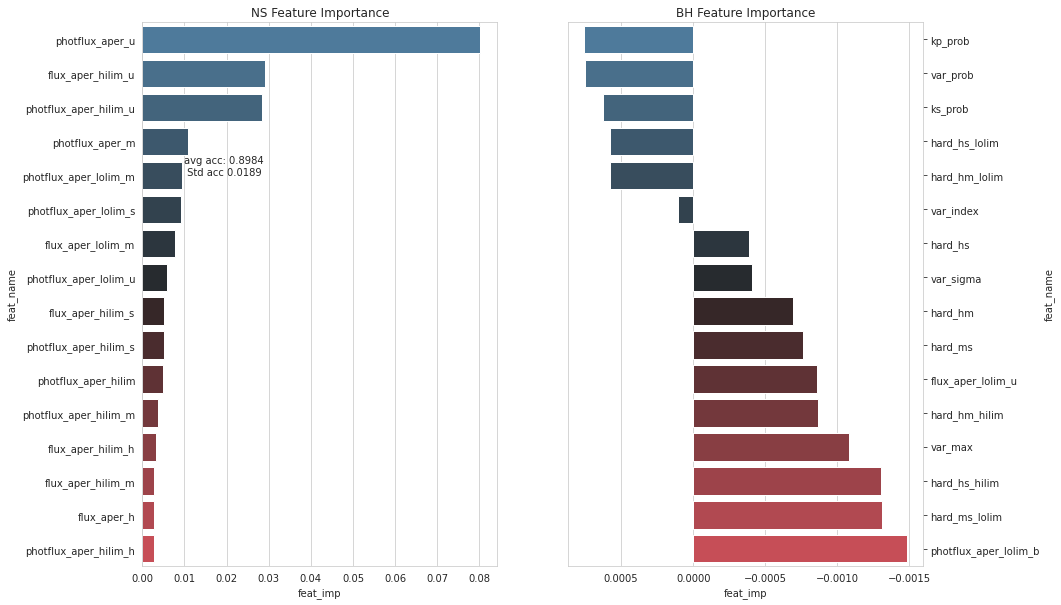

In [23]:
feat_names_sorted = ''
to_rem_ns = []
to_rem_bh = []
mean_acc = []
std_acc = [] 
num_params = []
roc_auc = []
f_bh , f_ns , fig , _ , _ , _ , _ = evaluate_clf(data_all , to_rem_ns , drop_brems=False)
for i in tqdm(range(4)):
    curr_imp_ns = f_ns.iloc[i]['feat_name']
    curr_imp_bh = f_bh.iloc[i]['feat_name']
    for j in tqdm(range(3)):
        next_corr = feat_feat_corr[[curr_imp_ns]].sort_values(by = curr_imp_ns , ascending=False ).iloc[j].name
        to_rem_ns.append(next_corr)
        next_corr = feat_feat_corr[[curr_imp_bh]].sort_values(by = curr_imp_bh , ascending=False ).iloc[j].name
        to_rem_bh.append(next_corr)
    to_rem = list(np.union1d(to_rem_ns , to_rem_bh))
    #print('Removing Params' , to_rem)
    f_bh , f_ns ,  fig , mean , std , n_params , ra = evaluate_clf(data_all , to_rem, drop_brems=False)
    mean_acc.append(mean)
    std_acc.append(std)
    roc_auc.append(ra)
    num_params.append(n_params)
    plt.savefig('result/plots/removing_params/no-model-fit/'+str(i)+'X'+str(j)+'.jpg')
    #plt.show()
    plt.close()

# Starting with Imputation

## Filtering Functions

In [55]:
def filter_data(data_sent):
    data = data_sent.copy()
    max_flux = -12
    min_flux = 26
    data = data[data['flux_aper']<max_flux]

    data = data[data['significance']>2]
    data_class = data[['class']]

    data_sig = data['significance']
    data_id = data['src_id']
    data_name = data['src_n']
    obs_info_params = [ 'livetime','likelihood','pileup_flag','mstr_sat_src_flag','mstr_streak_src_flag'   ,'gti_obs' , 'flux_significance_b'  , 'flux_significance_m' , 'flux_significance_s' , 'flux_significance_h' , 'flux_significance_u'    ]
    data_val = data.drop(columns=obs_info_params).reset_index(drop=True)
    return data_val

def norm_data(data_sent):
    data = data_sent.copy()
    #data.replace()
    for d in data:
        max_val = np.amax(data[d])
        min_val =  np.amin(data[d])
        data[d] = (data[d]-min_val)/(max_val-min_val)
    return data

def do_nothing(data_sent):
    return data_sent

def extract_data(data_sent , impute_fn = '',reduce_fn = ' ' , rf_impute=False):
    data = data_sent.copy()
    data = data.sample(frac=1)
    data = filter_data(data)
    #display(data)
    data_id = data[[ 'obs_id', 'class' ,'src_n' , 'src_id' ,'significance' , ]]
    data_id = data_id.reset_index(drop=True)
    data_val = data.drop([ 'obs_id', 'class' ,'src_n' , 'src_id' ,'significance' ,] , axis=1)
    data_val = reduce_fn(data_val)
    return data_val , data_id
   
from MissingValuesHandler.missing_data_handler import RandomForestImputer
def rf_impute(d, i ):
    data = pd.concat([i , d] , axis=1)
    data = data.drop(columns=['src_n' , 'src_id' , 'significance' , 'obs_id' ])
    rf_imputer = RandomForestImputer(
        data=data , 
        target_variable_name='class' , 
        forbidden_features_list=[] , 
        
    )
    rf_imputer.set_ensemble_model_parameters(n_estimators=400 , additional_estimators=100)
    new_data =  rf_imputer.train(sample_size = 0, path_to_save_dataset='processed_data/rf_imp.csv')
    new_data = new_data.drop(columns= ['class'])
    return new_data , rf_imputer

## Imputation

In [56]:

train_bh = pd.read_csv('../processed_data/BH_.csv' ,).drop('index' , axis=1)
train_bh = train_bh.sample(frac=1)

train_ns = pd.read_csv('../processed_data/NS_.csv'  ,).drop('index' , axis=1)
train_ns = train_ns.sample(frac=1)

train = pd.concat([train_bh , train_ns ] , axis=0)
#obs_id = ['OBS_'+str(i) for i in range(len(train))]
#train.insert( 0 , 'obs_id' , obs_id)
#train =  train.sample(frac=1).reset_index(drop=True)
model_fit_feat = ['powlaw_gamma','powlaw_gamma_hilim','powlaw_gamma_lolim','powlaw_nh','powlaw_nh_hilim','powlaw_nh_lolim','powlaw_ampl','powlaw_ampl_hilim','powlaw_ampl_lolim','powlaw_stat','bb_kt','bb_kt_hilim','bb_kt_lolim','bb_nh_hilim','bb_nh_lolim','bb_nh','bb_ampl','bb_ampl_lolim','bb_ampl_hilim','bb_stat','brems_kt','brems_kt_hilim','brems_kt_lolim','brems_nh','brems_nh_hilim','brems_nh_lolim','brems_stat' ,  'flux_powlaw_hilim','flux_powlaw_lolim','flux_powlaw','flux_brems_lolim','flux_brems_hilim','flux_brems','flux_bb_hilim','flux_bb_lolim','flux_bb',]

train = train.drop(columns=model_fit_feat)
train

class      obs_id                 src_n  src_id  livetime  significance  \
63     BH   BH_OBS_63  CXOU J100514.2-07423  BH0018  171955.9         16.29   
49     BH   BH_OBS_49  CXOU J100508.7-07444  BH0015   36978.6          3.88   
170    BH  BH_OBS_170  J1745-2900            BH0027   17827.6        337.00   
7      BH    BH_OBS_7  1E 1740.7-2942        BH0002   14448.3        166.94   
162    BH  BH_OBS_162  J1745-2900            BH0027   26801.3        337.00   
..    ...         ...                   ...     ...       ...           ...   
306    NS  NS_OBS_306  XMMU J004245.2+41172  NS0046    3910.5          4.71   
28     NS   NS_OBS_28  1A 1742-289           NS0001    5112.4        167.36   
390    NS  NS_OBS_390  SAXWFC J1748.1-2446.  NS0071   28597.0          2.75   
274    NS  NS_OBS_274  XMMU J004245.2+41172  NS0046    4144.3          4.71   
167    NS  NS_OBS_167  XMMU J004245.2+41172  NS0044    4106.7         49.26   

       likelihood  pileup_flag  mstr_sat_src_flag  mstr_streak_src_flag  ...  \
63     1238.38300        False              False                 False  ...   
49       68.84056        False              False                 False  ...   
170  462011.40000        False              False                 False  ...   
7    151803.00000        False              False                 False  ...   
162  462011.40000        False              False                 False  ...   
..            ...          ...                ...                   ...  ...   
306     162.72960        False              False                 False  ...   
28       21.89294        False              False                 False  ...   
390     139.68540        False              False                 False  ...   
274     162.72960        False              False                 False  ...   
167    9049.17500        False              False                 False  ...   

    var_inter_sigma  hard_hm  hard_hm_hilim  hard_hm_lolim  hard_hs  hard_ms  \
63     4.139120e-07  -0.6983        -0.4853        -0.8751  -0.8420  -0.3335   
49     7.636750e-07  -0.3186         0.0331        -0.6602  -0.5809  -0.2936   
170    4.811690e-04   0.8882         0.9975         0.6902   0.9994  -0.6221   
7      3.960122e-03   0.9906         0.9925         0.9888   0.9931   0.1399   
162    4.811690e-04   0.9994         1.0000         0.7114   0.9994  -0.3923   
..              ...      ...            ...            ...      ...      ...   
306             NaN   0.9994         1.0000        -0.2605  -0.9994  -0.9994   
28     2.257511e-03   0.9994         1.0000        -0.1618      NaN      NaN   
390    2.680500e-07   0.9994         1.0000        -0.2105  -0.9994  -0.9994   
274             NaN   0.9981         1.0000        -0.2705  -0.9994  -0.9994   
167    7.351000e-06  -0.0924         0.3791        -0.5603  -0.6121  -0.5184   

     hard_hs_hilim  hard_hs_lolim  hard_ms_hilim  hard_ms_lolim  
63         -0.7127        -0.9438        -0.1880        -0.4678  
49         -0.2967        -0.8214        -0.0418        -0.5228  
170         1.0000         0.4653         0.0581        -0.9425  
7           0.9963         0.9913         0.3654        -0.0743  
162         1.0000         0.6552         0.2592        -1.0000  
..             ...            ...            ...            ...  
306         0.1493        -1.0000         0.0131        -1.0000  
28             NaN            NaN            NaN            NaN  
390        -0.1818        -1.0000        -0.3442        -1.0000  
274         0.1205        -1.0000         0.0019        -1.0000  
167        -0.2130        -0.8838        -0.1305        -0.8001  

[639 rows x 72 columns]

In [57]:
data_val , data_id   = extract_data(train ,  impute_fn= rf_impute , reduce_fn= do_nothing , rf_impute=True )
data_val

flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080                NaN         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455                NaN                NaN                NaN   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261                NaN   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  flux_aper_lolim_s  \
0           -13.138645         -13.143030                NaN   
1           -13.652085         -13.643592                NaN   
2           -13.519706         -13.518271                NaN   
3           -13.872895         -13.925549                NaN   
4           -14.742561         -14.423774         -15.288699   
..                 ...                ...                ...   
455                NaN         -14.545308                NaN   
456         -14.060581         -14.089322                NaN   
457         -13.614394         -13.824198         -15.164309   
458         -14.082389         -14.456056                NaN   
459         -13.773142         -13.608183         -14.466355   

     flux_aper_lolim_u  flux_aper_lolim_m  flux_aper_lolim_h  \
0                  NaN                NaN         -13.323124   
1                  NaN                NaN         -14.438064   
2                  NaN                NaN         -14.673459   
3                  NaN                NaN         -14.975514   
4           -15.860751         -15.155647         -15.460422   
..                 ...                ...                ...   
455                NaN                NaN                NaN   
456                NaN                NaN         -15.291069   
457                NaN                NaN                NaN   
458                NaN                NaN                NaN   
459         -15.449772         -14.434624         -13.955460   

     flux_aper_lolim_b  ...  var_inter_sigma  hard_hm  hard_hm_hilim  \
0           -13.325323  ...     5.484750e-06   0.9994         1.0000   
1           -14.285586  ...     4.811690e-04   0.9994         1.0000   
2           -14.575282  ...     8.676740e-03   0.9994         1.0000   
3                  NaN  ...              NaN   0.9994         1.0000   
4           -14.658565  ...     6.238000e-07  -0.2523         0.0493   
..                 ...  ...              ...      ...            ...   
455         -15.856985  ...              NaN      NaN            NaN   
456         -15.344573  ...              NaN   0.9994         1.0000   
457                NaN  ...     1.266650e-06      NaN            NaN   
458                NaN  ...              NaN  -0.9994        -0.0031   
459         -13.705534  ...     7.351000e-06   0.0987         0.2305   

     hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  hard_hs_lolim  \
0           0.9463   0.9994  -0.9994         1.0000         0.8988   
1           0.5615   0.9994   0.5809         1.0000         0.6227   
2           0.5240   0.1387  -0.9994         0.5690        -0.5653   
3           0.2992   0.7933  -0.9994         1.0000        -0.0793   
4          -0.5590  -0.3123  -0.0562         0.0056        -0.6115   
..             ...      ...      ...            ...            ...   
455            NaN      NaN      NaN            NaN            NaN   
456         0.2655   0.9994  -0.9994         1.0000        -0.0019   
457            NaN  -0.4422      NaN         0.0806        -1.0000   
458        -1.0000  -0.9994  -0.1699         0.1031        -1.0000   
459        -0.0381  -0.0450  -0.1424         0.0918        -0.1

In [58]:
data_id 

obs_id class                 src_n  src_id  significance
0    NS_OBS_371    NS  SAXWFC J1744.9-2921.  NS0068          9.04
1    BH_OBS_126    BH  J1745-2900            BH0027        337.00
2    NS_OBS_122    NS  GRS 1741.9-2853       NS0021        376.06
3    NS_OBS_258    NS  XMMU J004245.2+41172  NS0046          4.71
4     BH_OBS_72    BH  CXOU J100515.4-07425  BH0019         17.39
..          ...   ...                   ...     ...           ...
455  NS_OBS_310    NS  XMMU J004245.2+41172  NS0046          4.71
456  NS_OBS_254    NS  XMMU J004245.2+41172  NS0046          4.71
457  NS_OBS_330    NS  J1748-2021#2          NS0056          6.25
458  NS_OBS_297    NS  XMMU J004245.2+41172  NS0046          4.71
459  NS_OBS_210    NS  XMMU J004245.2+41172  NS0044         49.26

[460 rows x 5 columns]

In [59]:
new_data , random_forest_imputer = rf_impute(data_val, data_id)



- 5021 VALUE(S) CONVERGED!
- 0 VALUE(S) REMAINING!

- ALL VALUES CONVERGED!

- TOTAL ITERATIONS: 5

- NEW DATASET SAVED in: processed_data/rf_imp.csv


In [60]:
new_data

flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080         -13.000000         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455         -14.000000         -13.000000         -14.000000   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261         -14.000000   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  flux_aper_lolim_s  \
0           -13.138645         -13.143030         -14.000000   
1           -13.652085         -13.643592         -14.000000   
2           -13.519706         -13.518271         -14.000000   
3           -13.872895         -13.925549         -14.000000   
4           -14.742561         -14.423774         -15.288699   
..                 ...                ...                ...   
455         -13.000000         -14.545308         -14.000000   
456         -14.060581         -14.089322         -14.000000   
457         -13.614394         -13.824198         -15.164309   
458         -14.082389         -14.456056         -14.000000   
459         -13.773142         -13.608183         -14.466355   

     flux_aper_lolim_u  flux_aper_lolim_m  flux_aper_lolim_h  \
0           -14.000000         -14.000000         -13.323124   
1           -14.000000         -14.000000         -14.438064   
2           -14.000000         -14.000000         -14.673459   
3           -14.000000         -14.000000         -14.975514   
4           -15.860751         -15.155647         -15.460422   
..                 ...                ...                ...   
455         -14.000000         -14.000000         -14.000000   
456         -14.000000         -14.000000         -15.291069   
457         -14.000000         -14.000000         -14.000000   
458         -14.000000         -14.000000         -14.000000   
459         -15.449772         -14.434624         -13.955460   

     flux_aper_lolim_b  ...  var_inter_sigma  hard_hm  hard_hm_hilim  \
0           -13.325323  ...     5.484750e-06   0.9994         1.0000   
1           -14.285586  ...     4.811690e-04   0.9994         1.0000   
2           -14.575282  ...     8.676740e-03   0.9994         1.0000   
3           -13.000000  ...     0.000000e+00   0.9994         1.0000   
4           -14.658565  ...     6.238000e-07  -0.2523         0.0493   
..                 ...  ...              ...      ...            ...   
455         -15.856985  ...     0.000000e+00   0.0000         0.0000   
456         -15.344573  ...     0.000000e+00   0.9994         1.0000   
457         -13.000000  ...     1.266650e-06   0.0000         0.0000   
458         -13.000000  ...     0.000000e+00  -0.9994        -0.0031   
459         -13.705534  ...     7.351000e-06   0.0987         0.2305   

     hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  hard_hs_lolim  \
0           0.9463   0.9994  -0.9994         1.0000         0.8988   
1           0.5615   0.9994   0.5809         1.0000         0.6227   
2           0.5240   0.1387  -0.9994         0.5690        -0.5653   
3           0.2992   0.7933  -0.9994         1.0000        -0.0793   
4          -0.5590  -0.3123  -0.0562         0.0056        -0.6115   
..             ...      ...      ...            ...            ...   
455         0.0000   0.0000   0.0000         0.0000         0.0000   
456         0.2655   0.9994  -0.9994         1.0000        -0.0019   
457         0.0000  -0.4422   0.0000         0.0806        -1.0000   
458        -1.0000  -0.9994  -0.1699         0.1031        -1.0000   
459        -0.0381  -0.0450  -0.1424         0.0918        -0.1

In [64]:
encoded_features

flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080         -13.000000         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455         -14.000000         -13.000000         -14.000000   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261         -14.000000   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  flux_aper_lolim_s  \
0           -13.138645         -13.143030         -14.000000   
1           -13.652085         -13.643592         -14.000000   
2           -13.519706         -13.518271         -14.000000   
3           -13.872895         -13.925549         -14.000000   
4           -14.742561         -14.423774         -15.288699   
..                 ...                ...                ...   
455         -13.000000         -14.545308         -14.000000   
456         -14.060581         -14.089322         -14.000000   
457         -13.614394         -13.824198         -15.164309   
458         -14.082389         -14.456056         -14.000000   
459         -13.773142         -13.608183         -14.466355   

     flux_aper_lolim_u  flux_aper_lolim_m  flux_aper_lolim_h  \
0           -14.000000         -14.000000         -13.323124   
1           -14.000000         -14.000000         -14.438064   
2           -14.000000         -14.000000         -14.673459   
3           -14.000000         -14.000000         -14.975514   
4           -15.860751         -15.155647         -15.460422   
..                 ...                ...                ...   
455         -14.000000         -14.000000         -14.000000   
456         -14.000000         -14.000000         -15.291069   
457         -14.000000         -14.000000         -14.000000   
458         -14.000000         -14.000000         -14.000000   
459         -15.449772         -14.434624         -13.955460   

     flux_aper_lolim_b  ...  var_inter_sigma  hard_hm  hard_hm_hilim  \
0           -13.325323  ...     5.484750e-06   0.9994         1.0000   
1           -14.285586  ...     4.811690e-04   0.9994         1.0000   
2           -14.575282  ...     8.676740e-03   0.9994         1.0000   
3           -13.000000  ...     0.000000e+00   0.9994         1.0000   
4           -14.658565  ...     6.238000e-07  -0.2523         0.0493   
..                 ...  ...              ...      ...            ...   
455         -15.856985  ...     0.000000e+00   0.0000         0.0000   
456         -15.344573  ...     0.000000e+00   0.9994         1.0000   
457         -13.000000  ...     1.266650e-06   0.0000         0.0000   
458         -13.000000  ...     0.000000e+00  -0.9994        -0.0031   
459         -13.705534  ...     7.351000e-06   0.0987         0.2305   

     hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  hard_hs_lolim  \
0           0.9463   0.9994  -0.9994         1.0000         0.8988   
1           0.5615   0.9994   0.5809         1.0000         0.6227   
2           0.5240   0.1387  -0.9994         0.5690        -0.5653   
3           0.2992   0.7933  -0.9994         1.0000        -0.0793   
4          -0.5590  -0.3123  -0.0562         0.0056        -0.6115   
..             ...      ...      ...            ...            ...   
455         0.0000   0.0000   0.0000         0.0000         0.0000   
456         0.2655   0.9994  -0.9994         1.0000        -0.0019   
457         0.0000  -0.4422   0.0000         0.0806        -1.0000   
458        -1.0000  -0.9994  -0.1699         0.1031        -1.0000   
459        -0.0381  -0.0450  -0.1424         0.0918        -0.1

In [65]:
sample_used                         = random_forest_imputer.get_sample()
features_type_prediction            = random_forest_imputer.get_features_type_predictions()
target_variable_type_prediction     = random_forest_imputer.get_target_variable_type_prediction()
encoded_features                    = random_forest_imputer.get_encoded_features()
encoded_target_variable             = random_forest_imputer.get_target_variable_encoded()
final_proximity_matrix              = random_forest_imputer.get_proximity_matrix()
final_distance_matrix               = random_forest_imputer.get_distance_matrix()
weighted_averages                   = random_forest_imputer.get_nan_features_predictions(option="all")
convergent_values                   = random_forest_imputer.get_nan_features_predictions(option="conv")
divergent_values                    = random_forest_imputer.get_nan_features_predictions(option="div")
ensemble_model_parameters           = random_forest_imputer.get_ensemble_model_parameters()
all_target_value_predictions        = random_forest_imputer.get_nan_target_values_predictions(option="all")
target_value_predictions            = random_forest_imputer.get_nan_target_values_predictions(option="one")


In [66]:
encoded_features_norm = norm_data(encoded_features)
encoded_features_norm

flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0             0.251029           0.433240           0.243151   
1             0.258639           0.375439           0.299045   
2             0.527350           0.645953           0.304024   
3             0.416179           0.562917           0.406659   
4             0.368579           0.227293           0.374731   
..                 ...                ...                ...   
455           0.597466           0.645953           0.569761   
456           0.469668           0.518826           0.459308   
457           0.520656           0.324572           0.569761   
458           0.440903           0.608393           0.473435   
459           0.524310           0.389729           0.506143   

     flux_aper_hilim_h  flux_aper_hilim_b  flux_aper_lolim_s  \
0             0.668253           0.658011           0.689134   
1             0.550434           0.542784           0.689134   
2             0.580811           0.571632           0.689134   
3             0.499764           0.477879           0.689134   
4             0.300202           0.363190           0.436365   
..                 ...                ...                ...   
455           0.700067           0.335213           0.689134   
456           0.456696           0.440179           0.689134   
457           0.559083           0.501209           0.460763   
458           0.451692           0.355759           0.689134   
459           0.522655           0.550935           0.597662   

     flux_aper_lolim_u  flux_aper_lolim_m  flux_aper_lolim_h  \
0             0.558162           0.644405           0.683859   
1             0.558162           0.644405           0.464287   
2             0.558162           0.644405           0.417929   
3             0.558162           0.644405           0.358443   
4             0.188362           0.417580           0.262947   
..                 ...                ...                ...   
455           0.558162           0.644405           0.550558   
456           0.558162           0.644405           0.296299   
457           0.558162           0.644405           0.550558   
458           0.558162           0.644405           0.550558   
459           0.270039           0.559099           0.559329   

     flux_aper_lolim_b  ...  var_inter_sigma   hard_hm  hard_hm_hilim  \
0             0.669132  ...         0.000246  1.000000       1.000000   
1             0.476238  ...         0.021622  1.000000       1.000000   
2             0.418045  ...         0.389903  1.000000       1.000000   
3             0.734481  ...         0.000000  1.000000       1.000000   
4             0.401316  ...         0.000028  0.373774       0.496345   
..                 ...  ...              ...       ...            ...   
455           0.160582  ...         0.000000  0.500000       0.470227   
456           0.263513  ...         0.000000  1.000000       1.000000   
457           0.734481  ...         0.000057  0.500000       0.470227   
458           0.734481  ...         0.000000  0.000000       0.468584   
459           0.592757  ...         0.000330  0.549380       0.592339   

     hard_hm_lolim   hard_hs   hard_ms  hard_hs_hilim  hard_hs_lolim  \
0         0.981097  1.000000  0.000000       1.000000       0.950588   
1         0.787126  1.000000  0.790624       1.000000       0.812365   
2         0.768223  0.569392  0.000000       0.778691       0.217622   
3         0.654905  0.896888  0.000000       1.000000       0.460926   
4         0.222301  0.343756  0.471883       0.489397       0.194493   
..             ...       ...       ...            ...            ...   
455       0.504083  0.500000  0.500000       0.486521       0.500626   
456       0.637917  1.000000  0.000000       1.000000       0.499675   
457       0.504083  0.278767  0.500000       0.527908       0.000000   
458       0.000000  0.000000  0.414999       0.539461       0.000000   
459       0.484878  0.477486 

In [67]:
data_id

obs_id class                 src_n  src_id  significance
0    NS_OBS_371    NS  SAXWFC J1744.9-2921.  NS0068          9.04
1    BH_OBS_126    BH  J1745-2900            BH0027        337.00
2    NS_OBS_122    NS  GRS 1741.9-2853       NS0021        376.06
3    NS_OBS_258    NS  XMMU J004245.2+41172  NS0046          4.71
4     BH_OBS_72    BH  CXOU J100515.4-07425  BH0019         17.39
..          ...   ...                   ...     ...           ...
455  NS_OBS_310    NS  XMMU J004245.2+41172  NS0046          4.71
456  NS_OBS_254    NS  XMMU J004245.2+41172  NS0046          4.71
457  NS_OBS_330    NS  J1748-2021#2          NS0056          6.25
458  NS_OBS_297    NS  XMMU J004245.2+41172  NS0046          4.71
459  NS_OBS_210    NS  XMMU J004245.2+41172  NS0044         49.26

[460 rows x 5 columns]

In [68]:
encoded_features

flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080         -13.000000         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455         -14.000000         -13.000000         -14.000000   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261         -14.000000   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  flux_aper_lolim_s  \
0           -13.138645         -13.143030         -14.000000   
1           -13.652085         -13.643592         -14.000000   
2           -13.519706         -13.518271         -14.000000   
3           -13.872895         -13.925549         -14.000000   
4           -14.742561         -14.423774         -15.288699   
..                 ...                ...                ...   
455         -13.000000         -14.545308         -14.000000   
456         -14.060581         -14.089322         -14.000000   
457         -13.614394         -13.824198         -15.164309   
458         -14.082389         -14.456056         -14.000000   
459         -13.773142         -13.608183         -14.466355   

     flux_aper_lolim_u  flux_aper_lolim_m  flux_aper_lolim_h  \
0           -14.000000         -14.000000         -13.323124   
1           -14.000000         -14.000000         -14.438064   
2           -14.000000         -14.000000         -14.673459   
3           -14.000000         -14.000000         -14.975514   
4           -15.860751         -15.155647         -15.460422   
..                 ...                ...                ...   
455         -14.000000         -14.000000         -14.000000   
456         -14.000000         -14.000000         -15.291069   
457         -14.000000         -14.000000         -14.000000   
458         -14.000000         -14.000000         -14.000000   
459         -15.449772         -14.434624         -13.955460   

     flux_aper_lolim_b  ...  var_inter_sigma  hard_hm  hard_hm_hilim  \
0           -13.325323  ...     5.484750e-06   0.9994         1.0000   
1           -14.285586  ...     4.811690e-04   0.9994         1.0000   
2           -14.575282  ...     8.676740e-03   0.9994         1.0000   
3           -13.000000  ...     0.000000e+00   0.9994         1.0000   
4           -14.658565  ...     6.238000e-07  -0.2523         0.0493   
..                 ...  ...              ...      ...            ...   
455         -15.856985  ...     0.000000e+00   0.0000         0.0000   
456         -15.344573  ...     0.000000e+00   0.9994         1.0000   
457         -13.000000  ...     1.266650e-06   0.0000         0.0000   
458         -13.000000  ...     0.000000e+00  -0.9994        -0.0031   
459         -13.705534  ...     7.351000e-06   0.0987         0.2305   

     hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  hard_hs_lolim  \
0           0.9463   0.9994  -0.9994         1.0000         0.8988   
1           0.5615   0.9994   0.5809         1.0000         0.6227   
2           0.5240   0.1387  -0.9994         0.5690        -0.5653   
3           0.2992   0.7933  -0.9994         1.0000        -0.0793   
4          -0.5590  -0.3123  -0.0562         0.0056        -0.6115   
..             ...      ...      ...            ...            ...   
455         0.0000   0.0000   0.0000         0.0000         0.0000   
456         0.2655   0.9994  -0.9994         1.0000        -0.0019   
457         0.0000  -0.4422   0.0000         0.0806        -1.0000   
458        -1.0000  -0.9994  -0.1699         0.1031        -1.0000   
459        -0.0381  -0.0450  -0.1424         0.0918        -0.1

In [69]:
processed_data_all = pd.concat([data_id , encoded_features] , axis=1)
processed_data_all

obs_id class                 src_n  src_id  significance  \
0    NS_OBS_371    NS  SAXWFC J1744.9-2921.  NS0068          9.04   
1    BH_OBS_126    BH  J1745-2900            BH0027        337.00   
2    NS_OBS_122    NS  GRS 1741.9-2853       NS0021        376.06   
3    NS_OBS_258    NS  XMMU J004245.2+41172  NS0046          4.71   
4     BH_OBS_72    BH  CXOU J100515.4-07425  BH0019         17.39   
..          ...   ...                   ...     ...           ...   
455  NS_OBS_310    NS  XMMU J004245.2+41172  NS0046          4.71   
456  NS_OBS_254    NS  XMMU J004245.2+41172  NS0046          4.71   
457  NS_OBS_330    NS  J1748-2021#2          NS0056          6.25   
458  NS_OBS_297    NS  XMMU J004245.2+41172  NS0046          4.71   
459  NS_OBS_210    NS  XMMU J004245.2+41172  NS0044         49.26   

     flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080         -13.000000         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455         -14.000000         -13.000000         -14.000000   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261         -14.000000   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  ...  var_inter_sigma  hard_hm  \
0           -13.138645         -13.143030  ...     5.484750e-06   0.9994   
1           -13.652085         -13.643592  ...     4.811690e-04   0.9994   
2           -13.519706         -13.518271  ...     8.676740e-03   0.9994   
3           -13.872895         -13.925549  ...     0.000000e+00   0.9994   
4           -14.742561         -14.423774  ...     6.238000e-07  -0.2523   
..                 ...                ...  ...              ...      ...   
455         -13.000000         -14.545308  ...     0.000000e+00   0.0000   
456         -14.060581         -14.089322  ...     0.000000e+00   0.9994   
457         -13.614394         -13.824198  ...     1.266650e-06   0.0000   
458         -14.082389         -14.456056  ...     0.000000e+00  -0.9994   
459         -13.773142         -13.608183  ...     7.351000e-06   0.0987   

     hard_hm_hilim  hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  \
0           1.0000         0.9463   0.9994  -0.9994         1.0000   
1           1.0000         0.5615   0.9994   0.5809         1.0000   
2           1.0000         0.5240   0.1387  -0.9994         0.5690   
3           1.0000         0.2992   0.7933  -0.9994         1.0000   
4           0.0493        -0.5590  -0.3123  -0.0562         0.0056   
..             ...            ...      ...      ...            ...   
455         0.0000         0.0000   0.0000   0.0000         0.0000   
456         1.0000         0.2655   0.9994  -0.9994         1.0000   
457         0.0000         0.0000  -0.4422   0.0000         0.0806   
458        -0.0031        -1.0000  -0.9994  -0.1699         0.1031   
459         0.2305        -0.0381  -0.0450  -0.1424         0.0918   

     hard_hs_lolim  hard_ms_hilim  hard_ms_lolim  
0           0.8988         0.0581        -1.0000  
1           0.6227         1.0000        -0.2330  
2          -0.5653        -0.5703        -1.0000  
3          -0.0793        -0.0106        -1.0000  
4          -0.6115         0.2067        -0.3067  
..             ...            ...            ...  
455         0.0000         0.0000         0.0000  
456        -0.0019         0.1018        -1.0000  
457        -1.0000         0.0000         0.0000  
458        -1.0000         0.6065        -0.5928  
459        -0.1830        -0.0119        -0.2692  

[460 rows x 61 columns]

In [70]:
processed_data_all.to_csv('../processed_data/train_none_rf_impute_no_model_fit')
processed_data_all

obs_id class                 src_n  src_id  significance  \
0    NS_OBS_371    NS  SAXWFC J1744.9-2921.  NS0068          9.04   
1    BH_OBS_126    BH  J1745-2900            BH0027        337.00   
2    NS_OBS_122    NS  GRS 1741.9-2853       NS0021        376.06   
3    NS_OBS_258    NS  XMMU J004245.2+41172  NS0046          4.71   
4     BH_OBS_72    BH  CXOU J100515.4-07425  BH0019         17.39   
..          ...   ...                   ...     ...           ...   
455  NS_OBS_310    NS  XMMU J004245.2+41172  NS0046          4.71   
456  NS_OBS_254    NS  XMMU J004245.2+41172  NS0046          4.71   
457  NS_OBS_330    NS  J1748-2021#2          NS0056          6.25   
458  NS_OBS_297    NS  XMMU J004245.2+41172  NS0046          4.71   
459  NS_OBS_210    NS  XMMU J004245.2+41172  NS0044         49.26   

     flux_aper_hilim_s  flux_aper_hilim_u  flux_aper_hilim_m  \
0           -15.393726         -14.082337         -15.397940   
1           -15.363111         -14.376441         -15.158703   
2           -14.282080         -13.000000         -15.137392   
3           -14.729321         -13.422508         -14.698102   
4           -14.920819         -15.130240         -14.834756   
..                 ...                ...                ...   
455         -14.000000         -13.000000         -14.000000   
456         -14.514137         -13.646853         -14.472757   
457         -14.309007         -14.635261         -14.000000   
458         -14.629857         -13.191114         -14.412289   
459         -14.294307         -14.303731         -14.272296   

     flux_aper_hilim_h  flux_aper_hilim_b  ...  var_inter_sigma  hard_hm  \
0           -13.138645         -13.143030  ...     5.484750e-06   0.9994   
1           -13.652085         -13.643592  ...     4.811690e-04   0.9994   
2           -13.519706         -13.518271  ...     8.676740e-03   0.9994   
3           -13.872895         -13.925549  ...     0.000000e+00   0.9994   
4           -14.742561         -14.423774  ...     6.238000e-07  -0.2523   
..                 ...                ...  ...              ...      ...   
455         -13.000000         -14.545308  ...     0.000000e+00   0.0000   
456         -14.060581         -14.089322  ...     0.000000e+00   0.9994   
457         -13.614394         -13.824198  ...     1.266650e-06   0.0000   
458         -14.082389         -14.456056  ...     0.000000e+00  -0.9994   
459         -13.773142         -13.608183  ...     7.351000e-06   0.0987   

     hard_hm_hilim  hard_hm_lolim  hard_hs  hard_ms  hard_hs_hilim  \
0           1.0000         0.9463   0.9994  -0.9994         1.0000   
1           1.0000         0.5615   0.9994   0.5809         1.0000   
2           1.0000         0.5240   0.1387  -0.9994         0.5690   
3           1.0000         0.2992   0.7933  -0.9994         1.0000   
4           0.0493        -0.5590  -0.3123  -0.0562         0.0056   
..             ...            ...      ...      ...            ...   
455         0.0000         0.0000   0.0000   0.0000         0.0000   
456         1.0000         0.2655   0.9994  -0.9994         1.0000   
457         0.0000         0.0000  -0.4422   0.0000         0.0806   
458        -0.0031        -1.0000  -0.9994  -0.1699         0.1031   
459         0.2305        -0.0381  -0.0450  -0.1424         0.0918   

     hard_hs_lolim  hard_ms_hilim  hard_ms_lolim  
0           0.8988         0.0581        -1.0000  
1           0.6227         1.0000        -0.2330  
2          -0.5653        -0.5703        -1.0000  
3          -0.0793        -0.0106        -1.0000  
4          -0.6115         0.2067        -0.3067  
..             ...            ...            ...  
455         0.0000         0.0000         0.0000  
456        -0.0019         0.1018        -1.0000  
457        -1.0000         0.0000         0.0000  
458        -1.0000         0.6065        -0.5928  
459        -0.1830        -0.0119        -0.2692  

[460 rows x 61 columns]

In [71]:
mds_coordinates = random_forest_imputer.get_mds_coordinates(n_dimensions=3, distance_matrix=final_distance_matrix)

col = ['c'+str(i) for i in range(mds_coordinates.shape[1])]
print(col)
mds_df = pd.DataFrame(mds_coordinates , columns =col)
mds_df.insert(0 , 'class' , data_id['class'])
mds_df.index.name = 'index'

['c0', 'c1', 'c2']


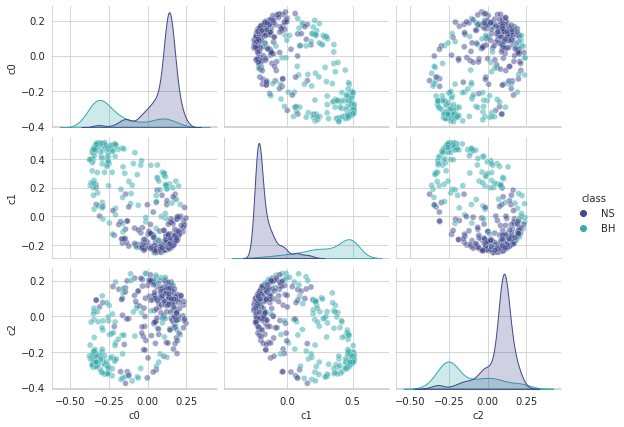

In [72]:
df = mds_df.copy()
#plt.figure(figsize=(6,6))

sns.pairplot(
    data = df , 
    #x = 'c1' , 
    hue= 'class' ,
    palette='mako' ,
    height= 2 , aspect=8/6    , 
    kind='scatter'  , 
    plot_kws = {'alpha': 0.5}
)
plt.show()


## RF

### Load Data

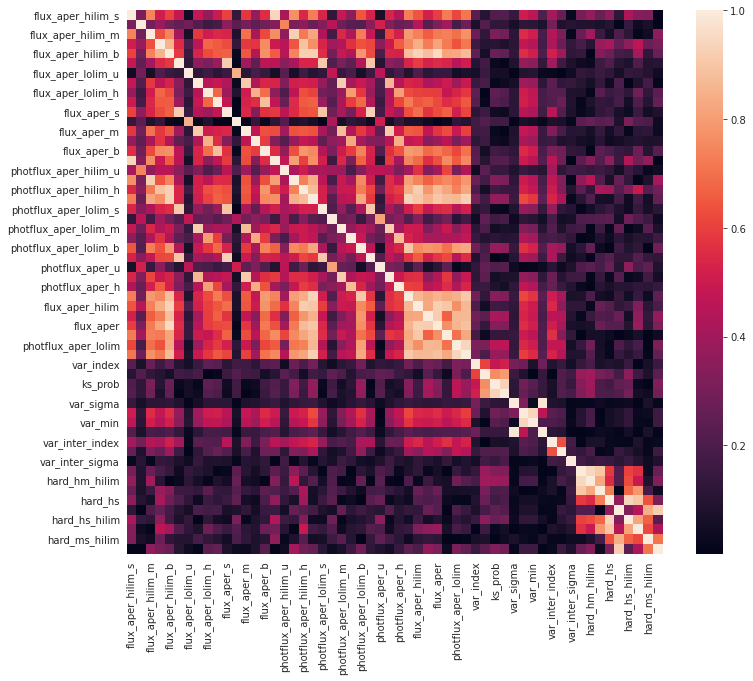

In [73]:
data_all =  pd.read_csv('../processed_data/train_none_rf_impute_no_model_fit' , index_col = 'obs_id').iloc[: , 1:]
feat_feat_corr = data_all.drop(columns=['class' , 'src_n' , 'src_id' , 'significance']).corr().abs()
feat_feat_corr
plt.figure(figsize=(12,10))
sns.heatmap(feat_feat_corr)
plt.show()

In [ ]:
feat_names_sorted = ''
to_rem_ns = []
to_rem_bh = []
mean_acc = []
std_acc = [] 
num_params = []
roc_auc = []
f_bh , f_ns , fig , _ , _ , _ , _ = evaluate_clf(data_all , to_rem_ns , drop_brems=False)
for i in tqdm(range(4)):
    curr_imp_ns = f_ns.iloc[i]['feat_name']
    curr_imp_bh = f_bh.iloc[i]['feat_name']
    for j in tqdm(range(3)):
        next_corr = feat_feat_corr[[curr_imp_ns]].sort_values(by = curr_imp_ns , ascending=False ).iloc[j].name
        to_rem_ns.append(next_corr)
        next_corr = feat_feat_corr[[curr_imp_bh]].sort_values(by = curr_imp_bh , ascending=False ).iloc[j].name
        to_rem_bh.append(next_corr)
    to_rem = list(np.union1d(to_rem_ns , to_rem_bh))
    #print('Removing Params' , to_rem)
    f_bh , f_ns ,  fig , mean , std , n_params , ra = evaluate_clf(data_all , to_rem, drop_brems=False)
    mean_acc.append(mean)
    std_acc.append(std)
    roc_auc.append(ra)
    num_params.append(n_params)
    #plt.savefig('result/plots/removing_params/no-model-fit/'+str(i)+'X'+str(j)+'.jpg')
    #plt.show()
    plt.close()